In [1]:
import os

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA

from panda.utils.data_utils import safe_standardize
from panda.utils.plot_utils import apply_custom_style

apply_custom_style("../../config/plotting.yaml")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/stor/home/jl82436/panda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
WORK = os.environ.get("WORK", "")
base_dir = f"{WORK}/physics-datasets"
re = 450
fpath = f"{base_dir}/von_karman_street/vortex_street_velocities_Re_{re}_4800timepoints.npz"

vfield = np.load(fpath, allow_pickle=True)
vx = vfield[..., 0]
vy = vfield[..., 1]
dvx = np.gradient(vx, 2 / vx.shape[1], axis=2)
dvy = np.gradient(vy, 1 / vy.shape[2], axis=1)
vort_field = dvy + dvx
vort_field_flattened = vort_field.reshape(vort_field.shape[0], -1)

In [3]:
n_components = 512
pca = PCA(n_components=n_components)
pca.fit(vort_field_flattened)
X_ts = pca.transform(vort_field_flattened)  # (T, D)
eigenvectors = pca.components_  # (D, H*W)

In [4]:
def reconstruct(pca_coeffs: np.ndarray, eigenvectors: np.ndarray, modes: int = -1) -> np.ndarray:
    if modes == -1:
        modes = pca_coeffs.shape[1]
    return pca_coeffs[:, :modes] @ eigenvectors[:modes, :]

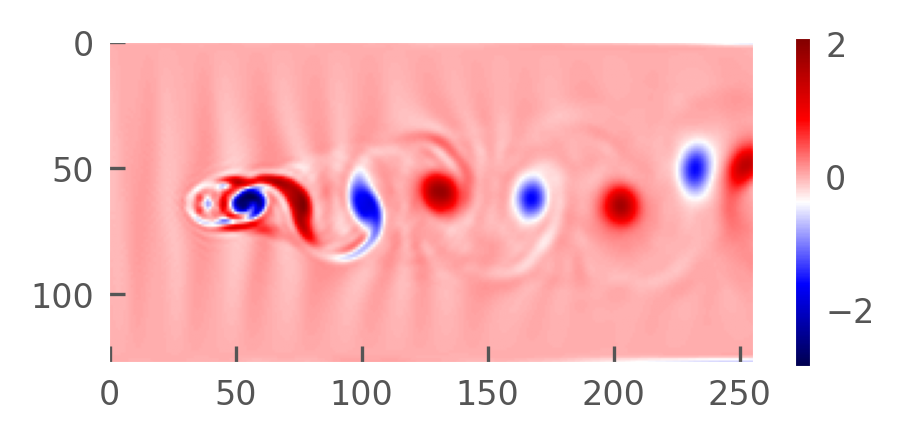

In [5]:
vort_recon = reconstruct(X_ts, eigenvectors)
vort_recon = vort_recon.reshape(vort_field.shape[0], vort_field.shape[1], vort_field.shape[2])
plt.figure()
plt.imshow(vort_recon[100 + 512, :, :].T, cmap="seismic")
plt.colorbar(shrink=0.5);

In [6]:
start_times = np.arange(0, 4096, 1024)
n_runs = len(start_times)
start_times = start_times.astype(int)
print(f"{len(start_times)} start_times: {start_times}")

4 start_times: [   0 1024 2048 3072]


In [7]:
stride = 1
context_length = 256
prediction_length = 256

In [8]:
trajs = np.stack([X_ts[start : start + context_length + prediction_length : stride] for start in start_times], axis=0)

In [9]:
import glob
import os


class KeepLatestBest(dde.callbacks.ModelCheckpoint):
    def __init__(self, fixed_prefix, **kwargs):
        super().__init__(filepath=fixed_prefix, **kwargs)
        self.fixed_prefix = fixed_prefix

    def on_epoch_end(self):
        super().on_epoch_end()  # lets DeepXDE save e.g. best-12345.pt
        files = sorted(glob.glob(self.filepath + "-*"))
        if not files:
            return
        latest = files[-1]
        _, ext = os.path.splitext(latest)
        fixed = self.fixed_prefix + ext
        for f in files[:-1]:
            os.remove(f)
        os.replace(latest, fixed)

In [ ]:
device_rank = 2
device = torch.device(f"cuda:{device_rank}")
torch.set_default_device(device)

# Trunk points = "component coordinates" (discrete index as a 1D coordinate in [0,1])
xs = np.linspace(0, 1, n_components).astype(np.float32).reshape(-1, 1)  # (N,1)

stand_trajs = safe_standardize(trajs, axis=1, context=trajs[:, :context_length])
# xtrain = (stand_trajs[:, : context_length - 1].astype(np.float32).reshape(-1, n_components), xs)
# ytrain = stand_trajs[:, 1:context_length].astype(np.float32).reshape(-1, n_components)

xtrain = (stand_trajs[:, :-1].astype(np.float32).reshape(-1, n_components), xs)
ytrain = stand_trajs[:, 1:].astype(np.float32).reshape(-1, n_components)
xtest = (stand_trajs[:, context_length:-1].astype(np.float32).reshape(-1, n_components), xs)
ytest = stand_trajs[:, context_length + 1 :].astype(np.float32).reshape(-1, n_components)

data = dde.data.TripleCartesianProd(X_train=xtrain, y_train=ytrain, X_test=xtest, y_test=ytest)

hidden_dim = 256
n_layers = 6
net = dde.nn.DeepONetCartesianProd(
    [n_components] + n_layers * [hidden_dim], [1] + n_layers * [hidden_dim], "gelu", "Glorot normal"
)

model = dde.Model(data, net)

batch_size = 512
iterations = 500000
ckpt = KeepLatestBest(
    "vkvs_ckpt/deeponet",
    save_better_only=True,
    monitor="test loss",
    period=1,
)

optimizer = torch.optim.AdamW(net.parameters(), lr=2e-4)
model.compile(optimizer, decay=("cosine", iterations, 1e-6), metrics=["mean l2 relative error"])
losshistory, train_state = model.train(iterations=iterations, batch_size=batch_size, callbacks=[ckpt])

dde.utils.plot_loss_history(losshistory)
plt.show()

Compiling model...
'compile' took 0.000130 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.15e+00]    [1.39e+00]    [1.00e+00]    
1000      [1.17e+00]    [1.38e+00]    [9.96e-01]    
2000      [1.17e+00]    [1.37e+00]    [9.92e-01]    
3000      [1.18e+00]    [1.36e+00]    [9.88e-01]    
4000      [1.15e+00]    [1.35e+00]    [9.84e-01]    
5000      [1.14e+00]    [1.33e+00]    [9.77e-01]    
6000      [1.10e+00]    [1.30e+00]    [9.68e-01]    
7000      [1.07e+00]    [1.28e+00]    [9.59e-01]    
8000      [1.13e+00]    [1.26e+00]    [9.51e-01]    
9000      [1.05e+00]    [1.24e+00]    [9.44e-01]    
10000     [1.05e+00]    [1.22e+00]    [9.37e-01]    
11000     [1.04e+00]    [1.20e+00]    [9.30e-01]    
12000     [1.01e+00]    [1.18e+00]    [9.24e-01]    
13000     [1.03e+00]    [1.17e+00]    [9.17e-01]    
14000     [1.02e+00]    [1.16e+00]    [9.14e-01]    
15000     [9.85e-01]    [1.14e+00]    [9.07e-01]    
16000     [9.82e-01]    [1.13e+00]

In [37]:
def rollout_deeponet(model, Z_feats, u0, steps):
    N = u0.shape[0]
    preds = np.empty((steps, N), dtype=np.float32)
    u = u0.astype(np.float32).copy()
    for s in range(steps):
        Vb = u.reshape(1, -1)  # branch: current state (1, N)
        preds[s] = model.predict((Vb, Z_feats))[0]  # next state (N,)
        u = preds[s]
    return preds  # (steps, N)

In [38]:
def plot_predicted_flow(
    prediction: torch.Tensor,
    trajectory: torch.Tensor,
    eigenvectors: torch.Tensor,
    num_modes: int,
    shape: tuple[int, int] = (vort_field.shape[1], vort_field.shape[2]),
    time_indices: list[int] | None = None,
    save_path: str | None = None,
    stride: int = 1,
    cmap_name="seismic",
    base_figsize=(5, 5),
    suptitle: str | None = None,
    suptitle_y: float = 1.0,
    **kwargs,
):
    recon = reconstruct(prediction[:, :num_modes], eigenvectors, modes=num_modes)
    recon = recon.reshape(-1, shape[0], shape[1])
    groundtruth = reconstruct(trajectory[:, :num_modes], eigenvectors, modes=num_modes)
    groundtruth = groundtruth.reshape(-1, shape[0], shape[1])
    vabs = max(np.abs(groundtruth.min()), np.abs(groundtruth.max()))

    if time_indices is None:
        time_indices = list(range(0, groundtruth.shape[0], stride))

    aspect_ratio = shape[0] / shape[1]
    fig = plt.figure(
        figsize=(
            base_figsize[0] * (len(time_indices)) / aspect_ratio,
            base_figsize[1] * aspect_ratio,
        )
    )
    gs = fig.add_gridspec(
        2,
        len(time_indices),
        width_ratios=[1] * (len(time_indices)),
        height_ratios=[1, 1],
        wspace=0,
        hspace=0,
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(len(time_indices))] for i in range(2)])
    for i, index in enumerate(time_indices):
        groundtruth_slice = groundtruth[index, :, :]
        recon_slice = recon[index, :, :]

        gax = axes[0, i].imshow(
            groundtruth_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )

        axes[0, i].spines["top"].set_visible(True)
        axes[0, i].spines["right"].set_visible(True)
        axes[0, i].spines["bottom"].set_visible(True)
        axes[0, i].spines["left"].set_visible(True)
        axes[0, i].spines["top"].set_color("black")
        axes[0, i].spines["right"].set_color("black")
        axes[0, i].spines["bottom"].set_color("black")
        axes[0, i].spines["left"].set_color("black")

        axes[0, i].set_title(
            "t = context" + (f" + {index + 1}" if index > 0 else ""),
            fontsize=12,
            fontweight="bold",
        )
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        rax = axes[1, i].imshow(
            recon_slice,
            vmin=-vabs,
            vmax=vabs,
            cmap=cmap_name,
        )
        axes[1, i].spines["top"].set_visible(True)
        axes[1, i].spines["right"].set_visible(True)
        axes[1, i].spines["bottom"].set_visible(True)
        axes[1, i].spines["left"].set_visible(True)
        axes[1, i].spines["top"].set_color("black")
        axes[1, i].spines["right"].set_color("black")
        axes[1, i].spines["bottom"].set_color("black")
        axes[1, i].spines["left"].set_color("black")

        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[0, i].add_patch(circle)
        circle = plt.Circle((0.5 * shape[1] + 1, 0.145 * shape[0]), 5, fill=True, color="black")
        axes[1, i].add_patch(circle)

    axes[0, 0].set_ylabel("Ground Truth", fontweight="bold", fontsize=16)
    axes[1, 0].set_ylabel("Predictions", fontweight="bold", fontsize=16)

    if suptitle is not None:
        plt.suptitle(suptitle, fontweight="bold", fontsize=18, ha="center", y=suptitle_y)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    else:
        plt.show()

In [39]:
# load best model
WORK_DIR = os.path.expandvars("$WORK")
# model.restore(f"{WORK_DIR}/checkpoints/VKVS_baselines/deeponet.pt", device=device)
model.restore("vkvs_ckpt/deeponet.pt", device=device)

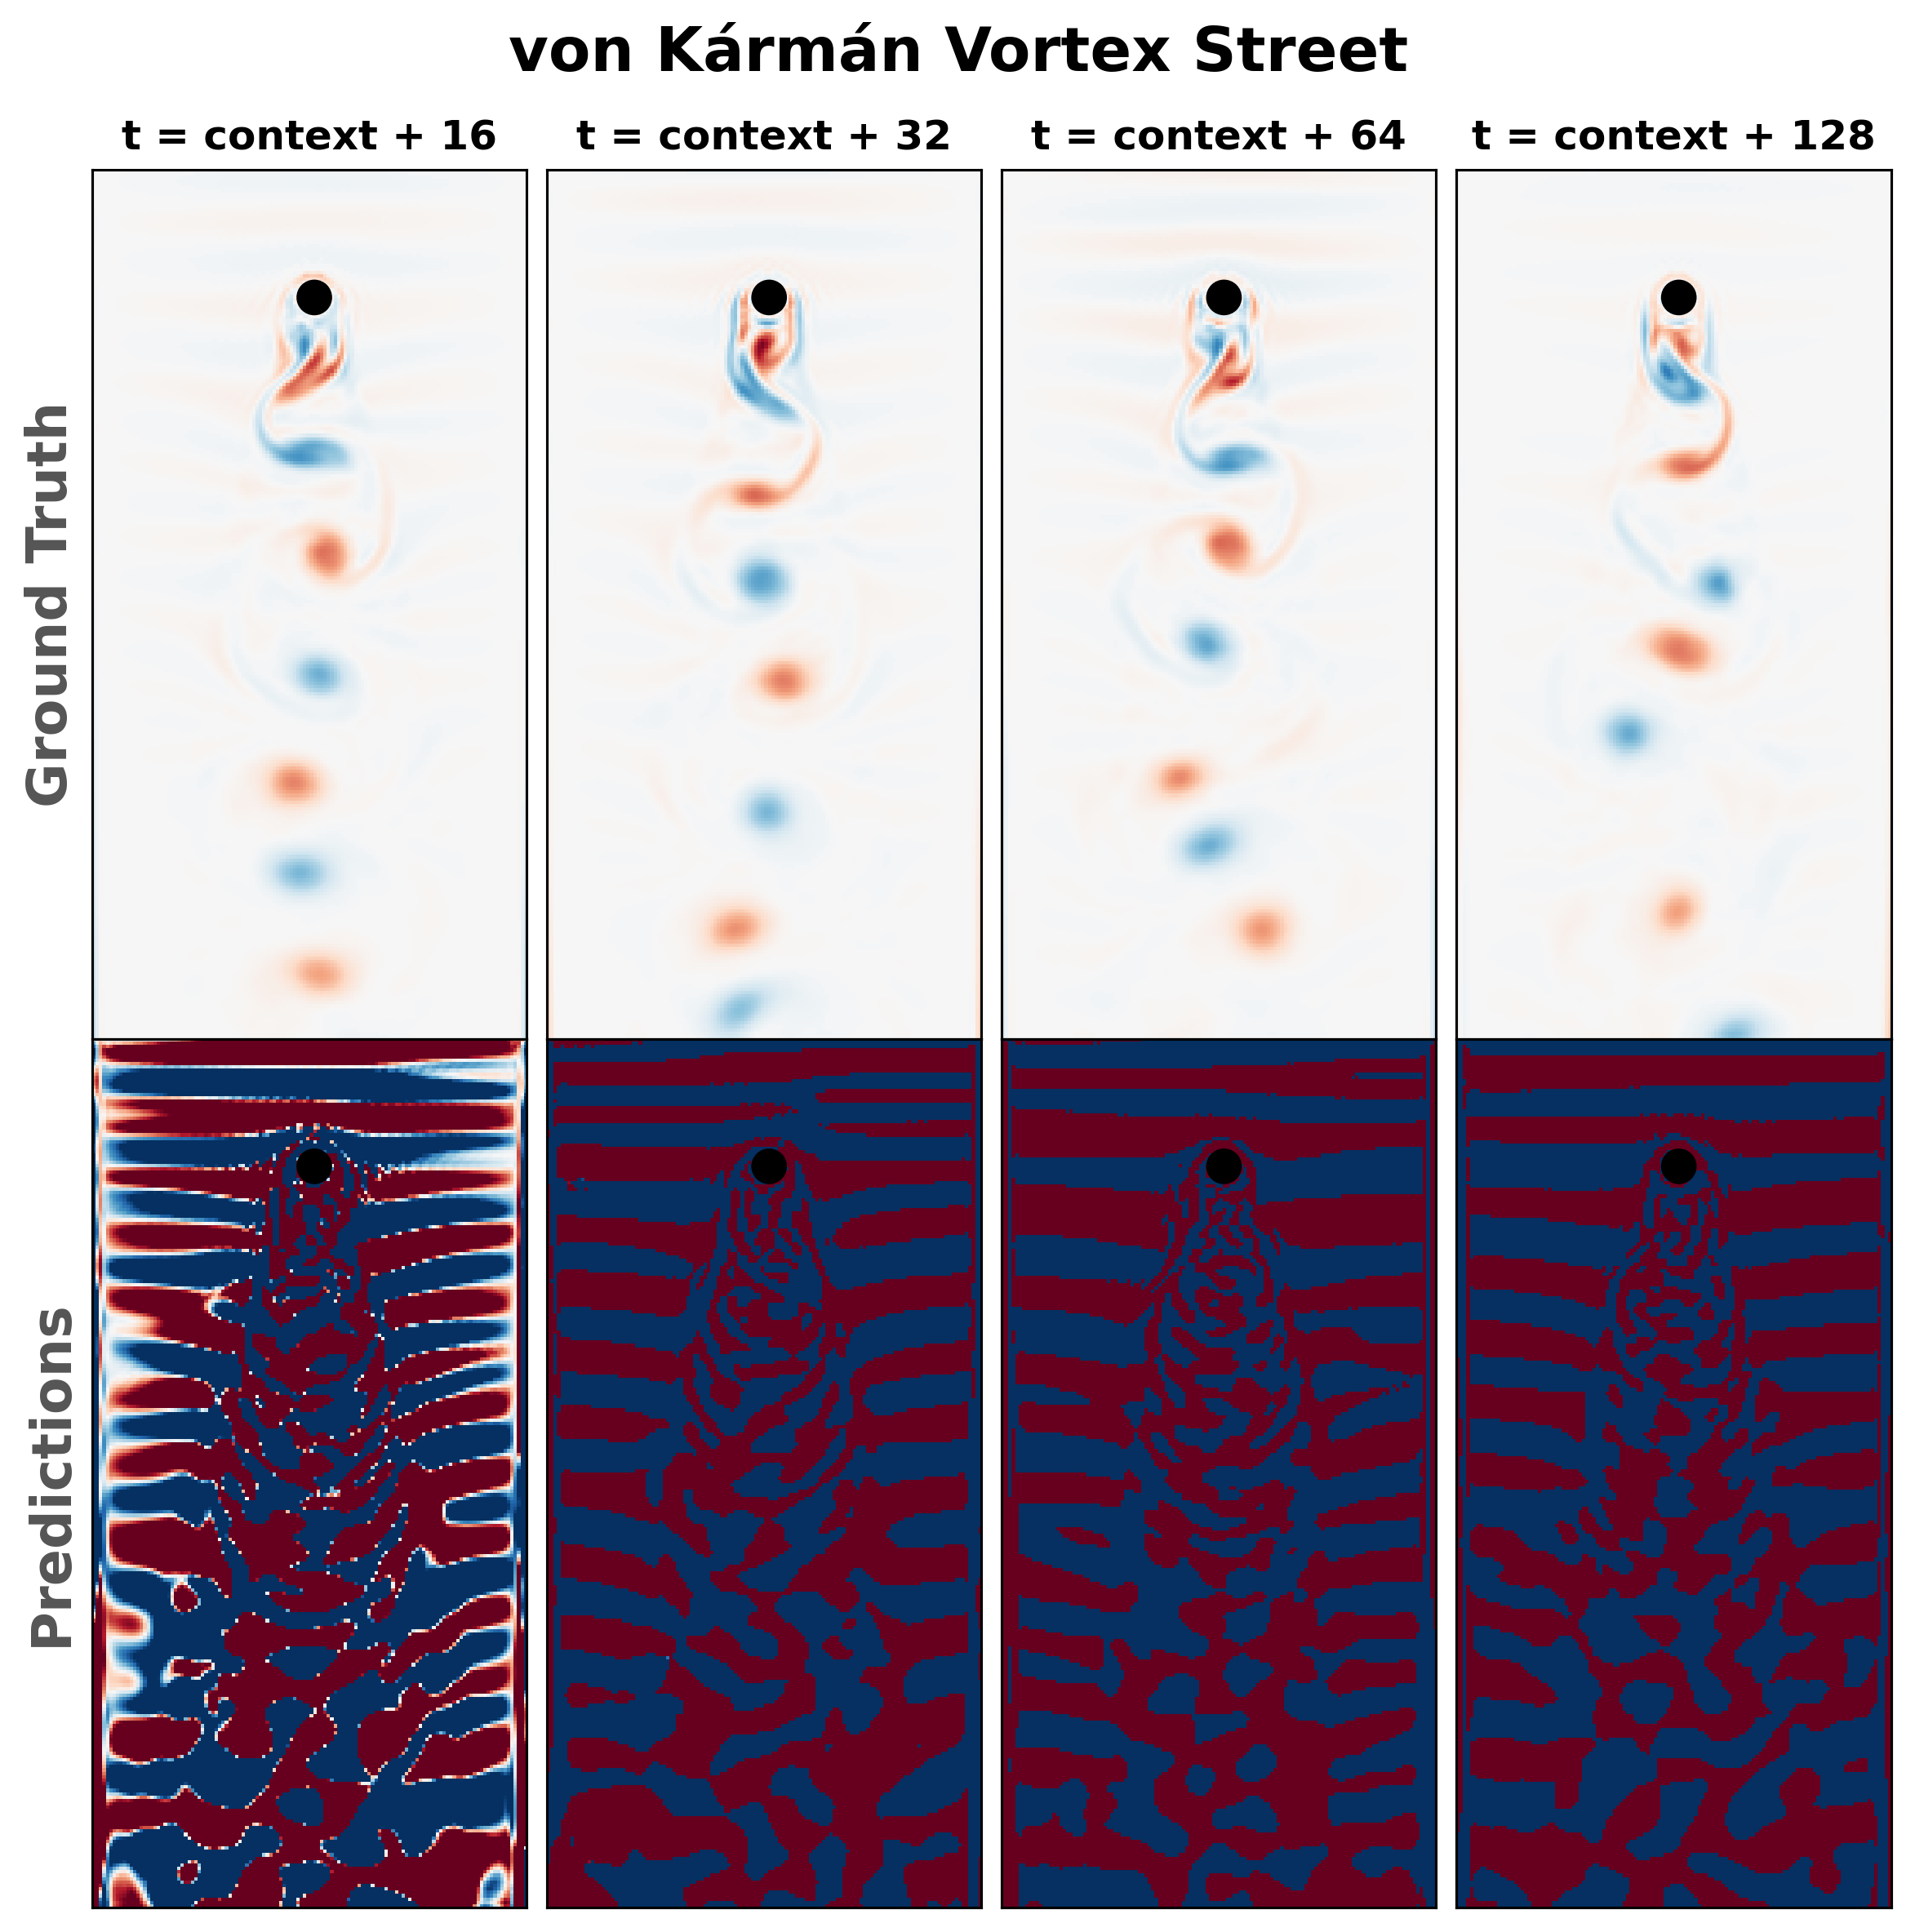

In [40]:
# visualize sample prediction
u0 = stand_trajs[0, context_length - 1].astype(np.float32)
prediction = rollout_deeponet(model, xs, u0, prediction_length)  # (prediction_length, N)
prediction = safe_standardize(prediction, axis=0, context=trajs[0, :context_length], denormalize=True)

plot_predicted_flow(
    prediction,
    trajs[0, context_length:],
    eigenvectors,
    num_modes=n_components,
    time_indices=[15, 31, 63, 127],
    cmap_name="RdBu",
    camera_ready=False,
    base_figsize=(4, 4),
    suptitle="von Kármán Vortex Street",
    suptitle_y=0.98,
)
